# Overview

This week, you've learned about access and utilizing remote databases, and more advanced topics for conducting logistic regression. Now, let's put these skills to the test!

You're working as a data scientist with a research firm that specializes in emergency management. In advance of client work, you've been asked to create and train a logistic regression model that can show off the firm's capabilities in disaster analysis.

Frequently after a disaster, researchers and firms will come in to give an independent review of an incident. While your firm doesn't have any current client data that it can share with you so that you may test and deploy your model, it does have data from the 1912 titanic disaster that it has stored in a remote database.

In this project, we'll be using data on passengers from the Titanic disaster to show off your analytical capabilities. The data is stored in a remote database, so you'll need to set up a connection and query the database (using Python!). After, you'll construct a logistic regression model and test/validate it's results so that it will be ready to deploy with a client.

Goal: Your job is to perform the following tasks:

- Collect your data from an AWS PostgreSQL instance, import it into your local PostgreSQL database, and then import with Python
- Perform any necessary data wrangling in advance of building your model
- Create a logistic regression model to figure out the likelihood of a passenger's survival
- Gridsearch optimal parameters for the logistic regression model
- Create a kNN model and optimize it's parameters with gridsearch
- Examine and explain the confusion matrices and ROC curves
- Create a report of your findings and detail the accuracy and assumptions of your model
- [BONUS] Change the decision threshold for positive labels using predicted probabilities
- [BONUS] Examine precision-recall instead of accuracy/ROC curves
- [VERY BONUS] Construct decision tree classifiers and bagging classifiers on the data

Pro Tip: Here are some questions to keep in mind:

What are we looking for? What is the hypothesis?
How can we train the model?
What is the overall goal of this research project you have been assigned?
Requirements

A local PostgreSQL database housing your remote data.
A Jupyter Notebook with the required problem statement, goals, and technical data.
A written report of your findings that detail the accuracy and assumptions of your model.

Bonus:

Create a blog post of at least 500 words (and 1-2 graphics!) describing your data, analysis, and approach. Link to it in your Jupyter notebook.
Necessary Deliverables / Submission

Materials must be in a clearly labeled Jupyter notebook.
Materials must be submitted via a Github PR to the instructor's repo.
Materials must be submitted by the end of week 5.
Starter code

Go ahead and grab the starter code to get started.

Dataset

Your data is stored within an AWS Postgres remote database. Here are your connection instructions:

Connecting to an AWS Postgres instance
PostgreSQL manual
We have imported the Titanic data into an AWS PostgreSQL instance, which you can find by connecting here:

psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
password: gastudents
Alternatively, you can use a python library like pandas, sqlalchemy, or psycopg.

Suggested Ways to Get Started

Read in your dataset
Write pseudocode before you write actual code. Thinking through the logic of something helps.
Read the docs for whatever technologies you use. Most of the time, there is a tutorial that you can follow, but not always, and learning to read documentation is crucial to your success!
Document everything.
Look up sample executive summaries online.

## Part 1: Aquire the Data

In [210]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
import sqlalchemy
%matplotlib inline
import seaborn as sns 
import sklearn.cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

#### 1. Connect to the remote database

In [211]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [212]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://postgres@localhost/titanic')
connection = engine.connect()

#### 2. Query the database and aggregate the data

In [213]:
titanic = connection.execute("select * from train;")
df = pd.DataFrame(titanic.fetchall())
df.columns = titanic.keys()
type(titanic)

sqlalchemy.engine.result.ResultProxy

In [214]:
df.drop('index', axis = 1)
#Another way:
#%%sql postgresql://postgres@localhost/titanic
#select * from train limit 5;
#titanic = %sql select * from train;

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,None,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,None,C


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


#### 5. What are the risks and assumptions of our data? 
There are many NAsem values so we need to fill them in. The most impopstant column needed to be filled in is 'Age'. One way is to try to calculate age as mean values in groups for 'Embarked'

In addition in column "Cabin"  just 204 values is filled out of 891. 

In [216]:
df["Age"].fillna(df.groupby("Embarked")["Age"].transform("mean"), inplace=True)
df.copy()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,None,S
5,5,6,0,3,"Moran, Mr. James",male,28.089286,0,0,330877,8.4583,None,Q
6,6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
7,7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,None,S
8,8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,None,S
9,9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,None,C


# 2. Exploratory Analysis

#### 1. Describe the Data

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


#### 2. Visualize the Data

In [218]:
x_values = np.array([df.Age])
y_values = np.array([df.Survived])
fare = np.array([df.Fare])

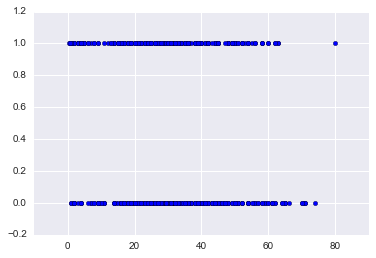

In [219]:
plt.scatter(x_values, y_values)

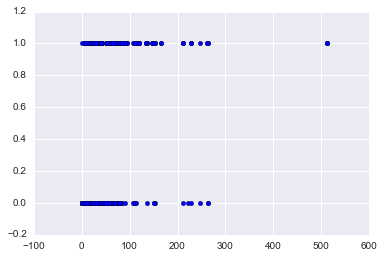

In [220]:
plt.scatter(fare, y_values)

In [221]:
(df[df.Survived==0]).count()

index          549
PassengerId    549
Survived       549
Pclass         549
Name           549
Sex            549
Age            549
SibSp          549
Parch          549
Ticket         549
Fare           549
Cabin           68
Embarked       549
dtype: int64

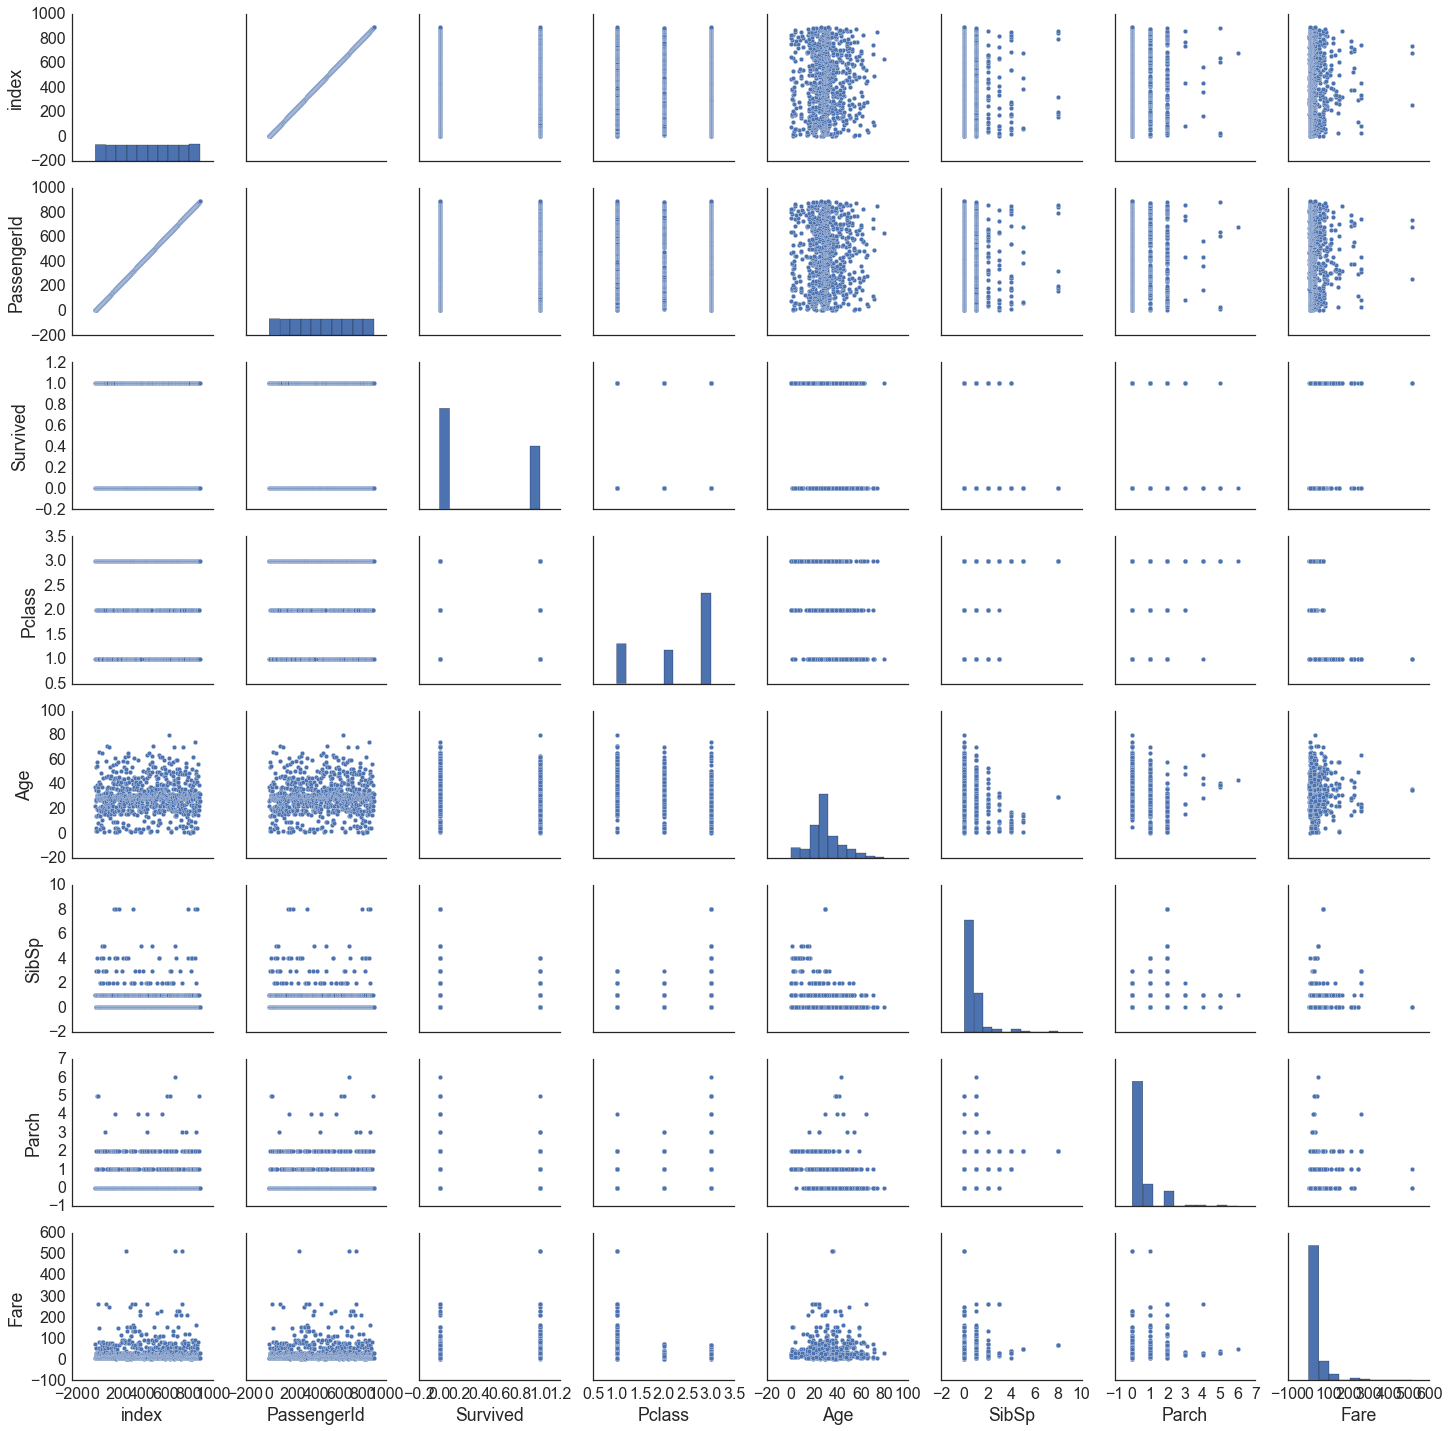

In [257]:
sns.pairplot(df)

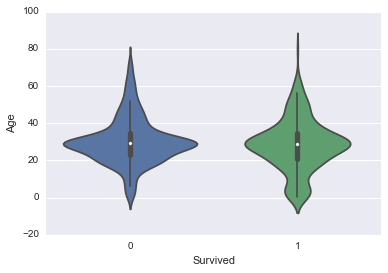

In [222]:
sns.violinplot(y='Age', x='Survived',   data=df)

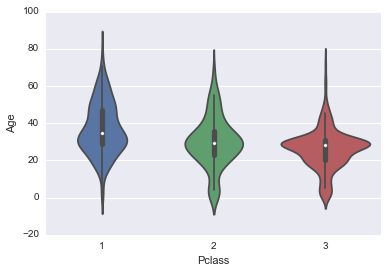

In [223]:
sns.violinplot(y='Age', x='Pclass',   data=df)

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [19]:
dummy_sex = pd.get_dummies(df.Sex)
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [224]:
import sklearn.dummy
dummy_classifier = sklearn.dummy.DummyClassifier(strategy='most_frequent')
sklearn.cross_validation.cross_val_score(dummy_classifier,
                                         dummy_sex,
                                         df.Survived,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.61111111,  0.61111111,  0.61797753,  0.61797753,  0.61797753,
        0.61797753,  0.61797753,  0.61797753,  0.61797753,  0.61363636])

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [225]:
columns = ['Age', 'Pclass', 'Gender', 'SibSp']

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [226]:
y = df.Survived.values
y

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1,

#### 3. Conduct the logistic regression

In [227]:
lr = sklearn.linear_model.LogisticRegression()
lr.fit(df[['Age']] ,y)
predictions = lr.predict([ [age] for age in range(0,101)  ])

#### 4. Examine the coefficients to see our correlations

array([[ 0.53483389,  0.46516611],
       [ 0.53765121,  0.46234879],
       [ 0.54046613,  0.45953387],
       [ 0.54327846,  0.45672154],
       [ 0.54608805,  0.45391195],
       [ 0.5488947 ,  0.4511053 ],
       [ 0.55169824,  0.44830176],
       [ 0.5544985 ,  0.4455015 ],
       [ 0.5572953 ,  0.4427047 ],
       [ 0.56008848,  0.43991152],
       [ 0.56287785,  0.43712215],
       [ 0.56566326,  0.43433674],
       [ 0.56844452,  0.43155548],
       [ 0.57122148,  0.42877852],
       [ 0.57399396,  0.42600604],
       [ 0.57676179,  0.42323821],
       [ 0.57952481,  0.42047519],
       [ 0.58228286,  0.41771714],
       [ 0.58503577,  0.41496423],
       [ 0.58778338,  0.41221662],
       [ 0.59052554,  0.40947446],
       [ 0.59326207,  0.40673793],
       [ 0.59599283,  0.40400717],
       [ 0.59871766,  0.40128234],
       [ 0.60143639,  0.39856361],
       [ 0.60414889,  0.39585111],
       [ 0.60685499,  0.39314501],
       [ 0.60955455,  0.39044545],
       [ 0.61224742,

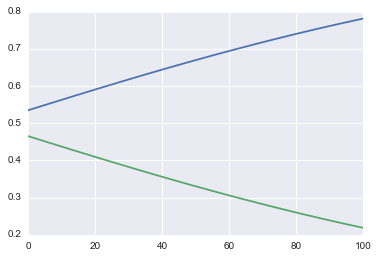

In [228]:
probabilities = lr.predict_proba([ [age] for age in range(0,101)  ])
plt.plot(probabilities)
probabilities

In [229]:
df['Gender'] = np.where(df.Sex == 'male',1, 0)

In [232]:
sklearn.cross_validation.cross_val_score(lr,
                                         df[['Age']],
                                         y,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.61111111,  0.61111111,  0.61797753,  0.61797753,  0.61797753,
        0.61797753,  0.61797753,  0.61797753,  0.61797753,  0.61363636])

In [233]:
import sklearn.dummy
dummy_classifier = sklearn.dummy.DummyClassifier(strategy='most_frequent')
sklearn.cross_validation.cross_val_score(dummy_classifier,
                                         df[['Age']],
                                         y,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.61111111,  0.61111111,  0.61797753,  0.61797753,  0.61797753,
        0.61797753,  0.61797753,  0.61797753,  0.61797753,  0.61363636])

In [234]:
lr.fit(df[['Pclass']], y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [235]:
sklearn.cross_validation.cross_val_score(lr,
                                         df[['Age', 'Pclass']],
                                         y,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.64444444,  0.61111111,  0.6741573 ,  0.70786517,  0.71910112,
        0.70786517,  0.74157303,  0.75280899,  0.73033708,  0.70454545])

In [236]:
lr.predict([  [1], [2], [3]  ])

array([1, 0, 0], dtype=int64)

In [237]:
lr.predict_proba([  [1], [2], [3]  ])

array([[ 0.36508232,  0.63491768],
       [ 0.56645721,  0.43354279],
       [ 0.7480416 ,  0.2519584 ]])

In [238]:
lr.fit(df[['Age', 'Pclass']],y)
lr.predict_proba([ [21,1] , [0,2]   , [25, 3]])

array([[ 0.2601345 ,  0.7398655 ],
       [ 0.32301856,  0.67698144],
       [ 0.74598433,  0.25401567]])

In [240]:
sklearn.cross_validation.cross_val_score(lr,
                                         df[['Age', 'Pclass', 'Gender']],
                                         y,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.8       ,  0.8       ,  0.7752809 ,  0.87640449,  0.80898876,
        0.76404494,  0.7752809 ,  0.76404494,  0.82022472,  0.77272727])

In [241]:
sklearn.cross_validation.cross_val_score(dummy_classifier,
                                         df[['Age', 'Pclass', 'Gender']],
                                         y,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.61111111,  0.61111111,  0.61797753,  0.61797753,  0.61797753,
        0.61797753,  0.61797753,  0.61797753,  0.61797753,  0.61363636])

In [242]:
lr.fit(df[['Age', 'Pclass', 'Gender']],y)
lr.predict_proba([ [21,1, 0] , [0,2, 0]   , [25, 3, 1]])

array([[ 0.08271281,  0.91728719],
       [ 0.12599958,  0.87400042],
       [ 0.88711846,  0.11288154]])

In [243]:
sklearn.cross_validation.cross_val_score(lr,
                                         df[['Age', 'Pclass', 'Gender', 'SibSp']],
                                         y,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.81111111,  0.78888889,  0.7752809 ,  0.84269663,  0.80898876,
        0.78651685,  0.80898876,  0.75280899,  0.83146067,  0.78409091])

In [244]:
sklearn.cross_validation.cross_val_score(dummy_classifier,
                                         df[['Age', 'Pclass', 'Gender', 'SibSp']],
                                         y,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.61111111,  0.61111111,  0.61797753,  0.61797753,  0.61797753,
        0.61797753,  0.61797753,  0.61797753,  0.61797753,  0.61363636])

In [245]:
lr.fit(df[['Age', 'Pclass', 'Gender', 'SibSp']],y)
lr.predict_proba([ [21,1, 0, 4] , [0,2, 0, 2]   , [25, 3, 1,0]])

array([[ 0.18562576,  0.81437424],
       [ 0.1567507 ,  0.8432493 ],
       [ 0.87212847,  0.12787153]])

In [246]:
sklearn.cross_validation.cross_val_score(lr,
                                         df[['Age', 'Pclass', 'Gender', 'SibSp', 'Fare']],
                                         y,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.8       ,  0.78888889,  0.7752809 ,  0.83146067,  0.78651685,
        0.76404494,  0.79775281,  0.76404494,  0.84269663,  0.79545455])

In [66]:
lr.coef_

array([[-0.02864342, -0.97014664, -2.4888379 , -0.2862767 ]])

#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [273]:
columns = ['Age', 'Pclass', 'Gender', 'Parch', 'SibSp']
(X_train, X_test, y_train, y_test) = sklearn.cross_validation.train_test_split(
  df[columns],
  y
)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(668, 5)
(223, 5)
(668L,)
(223L,)


In [274]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 7. Predict the class labels for the *Test* set

In [280]:
predictions = lr.predict(X_test)
predictions

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

#### 8. Predict the class probabilities for the *Test* set

In [255]:
lr.predict_proba(X_test)

array([[ 0.86228626,  0.13771374],
       [ 0.69748857,  0.30251143],
       [ 0.87937294,  0.12062706],
       [ 0.8565855 ,  0.1434145 ],
       [ 0.87937294,  0.12062706],
       [ 0.56494109,  0.43505891],
       [ 0.56494109,  0.43505891],
       [ 0.08325693,  0.91674307],
       [ 0.32721126,  0.67278874],
       [ 0.68349385,  0.31650615],
       [ 0.84527332,  0.15472668],
       [ 0.31430373,  0.68569627],
       [ 0.72755495,  0.27244505],
       [ 0.8565855 ,  0.1434145 ],
       [ 0.89082127,  0.10917873],
       [ 0.35959247,  0.64040753],
       [ 0.94136083,  0.05863917],
       [ 0.10696788,  0.89303212],
       [ 0.22207679,  0.77792321],
       [ 0.92778797,  0.07221203],
       [ 0.39113642,  0.60886358],
       [ 0.52425347,  0.47574653],
       [ 0.88799129,  0.11200871],
       [ 0.87570785,  0.12429215],
       [ 0.08693068,  0.91306932],
       [ 0.19866199,  0.80133801],
       [ 0.87937294,  0.12062706],
       [ 0.90680228,  0.09319772],
       [ 0.73557199,

#### 10. Cross validate the test set

In [256]:
sklearn.cross_validation.cross_val_score(lr,
                                         X_test,
                                         y_test,
                                         cv=10,
                                         scoring='accuracy')

array([ 0.75      ,  0.73913043,  0.72727273,  0.86363636,  0.86363636,
        0.77272727,  0.90909091,  0.72727273,  0.86363636,  0.63636364])

#### 11. Check the Classification Report

In [257]:
print sklearn.metrics.classification_report(y_test, predictions)

             precision    recall  f1-score   support

          0       0.78      0.86      0.82       131
          1       0.77      0.66      0.71        92

avg / total       0.78      0.78      0.78       223



#### 12. What do the classification metrics tell us?

In [258]:
sklearn.metrics.precision_score(y_test, predictions)

0.77215189873417722

Metrics allows us to evaluate the quality of predictions of a model.

#### 13. Check the Confusion Matrix

In [259]:
conmat = np.array(confusion_matrix(y_test, predictions))
conmat

array([[113,  18],
       [ 31,  61]])

In [260]:
confusion_dataframe = pd.DataFrame(
  {'predictions' : y_test,
   'actuals': predictions
   }
)
true_positives = (
  (confusion_dataframe.predictions == confusion_dataframe.actuals) &
  (confusion_dataframe.predictions == True)
)
true_negatives = (
  (confusion_dataframe.predictions == confusion_dataframe.actuals) &
  (confusion_dataframe.predictions == False)
)
false_negatives = (
  (confusion_dataframe.actuals == True) &
  (confusion_dataframe.predictions == False)
)
false_positives = (
  (confusion_dataframe.actuals == False) &
  (confusion_dataframe.predictions == True)
)
print "True positives:", true_positives.sum()
print "True negatives:", true_negatives.sum()
print "False negatives:", false_negatives.sum()
print "False positives:", false_positives.sum()

True positives: 61
True negatives: 113
False negatives: 18
False positives: 31


#### 14. What does the Confusion Matrix tell us? 
There are 61 True Positive values against 31 False Positive and 113 T.Negative values against just 18 False Negative. This means that our predictions are quite close to the fact

### 15. Plot the ROC curve

In [261]:
lr.predict_proba(X_test)

array([[ 0.86228626,  0.13771374],
       [ 0.69748857,  0.30251143],
       [ 0.87937294,  0.12062706],
       [ 0.8565855 ,  0.1434145 ],
       [ 0.87937294,  0.12062706],
       [ 0.56494109,  0.43505891],
       [ 0.56494109,  0.43505891],
       [ 0.08325693,  0.91674307],
       [ 0.32721126,  0.67278874],
       [ 0.68349385,  0.31650615],
       [ 0.84527332,  0.15472668],
       [ 0.31430373,  0.68569627],
       [ 0.72755495,  0.27244505],
       [ 0.8565855 ,  0.1434145 ],
       [ 0.89082127,  0.10917873],
       [ 0.35959247,  0.64040753],
       [ 0.94136083,  0.05863917],
       [ 0.10696788,  0.89303212],
       [ 0.22207679,  0.77792321],
       [ 0.92778797,  0.07221203],
       [ 0.39113642,  0.60886358],
       [ 0.52425347,  0.47574653],
       [ 0.88799129,  0.11200871],
       [ 0.87570785,  0.12429215],
       [ 0.08693068,  0.91306932],
       [ 0.19866199,  0.80133801],
       [ 0.87937294,  0.12062706],
       [ 0.90680228,  0.09319772],
       [ 0.73557199,

In [295]:
Y_scoring = lr.decision_function(X_test)
Y_scoring

array([ 0.52357059, -0.50098347,  0.96108971,  1.12885523, -1.98037987,
        0.77119219, -0.73261124, -1.71155275,  0.09928559,  0.99211978,
        0.89722746, -0.04919085,  1.95859878, -2.02038978, -1.94547842,
       -1.71155275, -0.30702815,  0.33147962, -1.63434349, -1.84023485,
        1.66267765, -1.01478536, -1.80069804,  0.75925615,  1.15459165,
       -2.0156226 , -1.29835908, -2.48178098, -1.98037987,  1.90235877,
        1.16839203, -0.21376322, -1.44748394, -1.94318052,  1.52824852,
       -1.84023485,  0.36915207,  2.24886825, -0.86129334,  2.09974339,
        1.59740442, -2.16100791,  1.02590955, -1.98037987,  0.52357059,
       -2.2496801 ,  0.42062491, -1.40130476, -2.12333546, -4.12948803,
        1.51490151, -2.07186262, -2.282276  , -0.9518496 ,  0.52357059,
       -0.72022182, -2.32922681,  0.36685418, -1.78876201, -1.98037987,
       -0.37230137, -1.89170768,  0.70513649,  0.36685418,  1.91694163,
       -1.89170768, -1.98037987, -0.9518496 , -2.39356786, -2.84

In [296]:
fpr, tpr, sorted_decision_function_data = sklearn.metrics.roc_curve(y_test, Y_scoring)

In [297]:
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' States', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_test, Y_scoring):
    fpr, tpr, _ = roc_curve(y_test, Y_scoring)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')

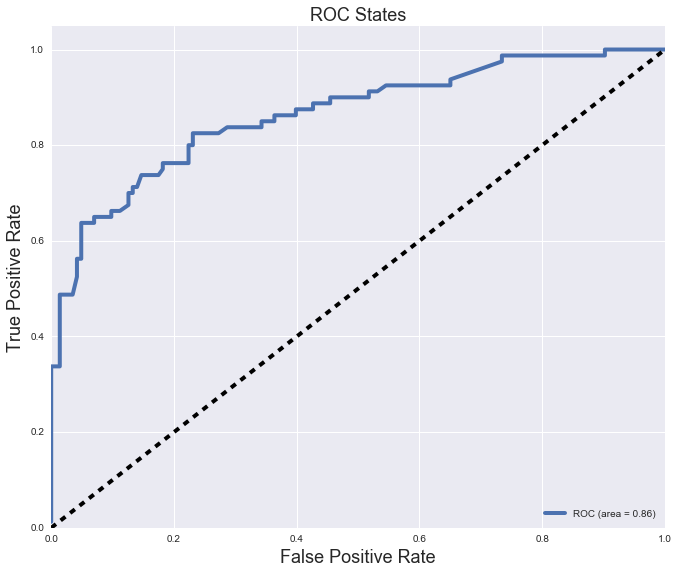

In [299]:
plot_roc(y_test, Y_scoring)

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [161]:
import sklearn.grid_search

In [166]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50)
}

In [167]:
searcher = sklearn.grid_search.GridSearchCV(lr, logreg_parameters, cv=5)
searcher.fit(df[columns], df.Survived)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...    2.44205e+00,   3.23746e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [168]:
searcher.best_score_

0.7991021324354658

In [169]:
searcher.best_params_

{'C': 0.10985411419875572, 'penalty': 'l2'}

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

L2 (Ridge) shrinks all the coefficient by the same proportions but eliminates none, while L1 (Lasso) can shrink some coefficients to zero, performing variable selection. In our case features are chosen carefully so we might need to shrink 

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

In case when we need to get rid of some irrelevant features (perform feature selection), we need to use Lasso. If our goal to reduce variance error, we use Ridge 

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [302]:
def make_prediction(x, threshold=0.9):
    if x[1] >= threshold:
        return 1
    else:
        return 0

new_predictions = map(make_prediction, lr.predict_proba(X_test))
#new_predictions == logreg.predict(X_test)

new_conmat = np.array(confusion_matrix(y_test, new_predictions))
new_confusion = pd.DataFrame(new_conmat, 
                         index=['Not_survived', 'Suvived'],
                         columns=['Predicted_Not_Survived','predicted_Survived'])

print(new_confusion)

              Predicted_Not_Survived  predicted_Survived
Not_survived                     143                   0
Suvived                           77                   3


Now there are no False Positive values but at the same time forecast became more pessimistic(more False Negatives)

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [188]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold

In [189]:
params = {'n_neighbors': range(2,60),
         'weights': ['uniform']
         }

gsknn = GridSearchCV(KNeighborsClassifier(),
                     params, n_jobs=-1,
                     cv=KFold(len(df.Survived), n_folds=3, shuffle=True))

In [190]:
gsknn.fit(df[columns], df.Survived)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=891, n_folds=3, shuffle=True, random_state=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 'weights': ['uniform']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [191]:
gsknn.best_params_

{'n_neighbors': 3, 'weights': 'uniform'}

In [192]:
gsknn.best_score_

0.76655443322109984

In [193]:
gsknn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?



Increasing n_neighbors will decrease variance and increase bias. While decreasing n_neighbors will increase variance and decrease bias.

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

Logistic Regression is better when you are dealing with very high dimension data( example - Text classification)

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [197]:
params = {'n_neighbors': [3],
         'weights': ['uniform']
         }

gsknn2 = GridSearchCV(KNeighborsClassifier(),
                     params, n_jobs=-1,
                     cv=KFold(len(df.Survived), n_folds=3, shuffle=True))

In [198]:
gsknn2.fit(df[columns], df.Survived)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=891, n_folds=3, shuffle=True, random_state=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3], 'weights': ['uniform']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [199]:
gsknn2.best_score_

0.77216610549943887

In [267]:
knn_predict = gsknn2.predict(X_test)

In [268]:
gsknn2.predict_proba(X_test)

array([[ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 0.66666667,  0.33333333],
       [ 1.        ,  0.        ],
       [ 0.66666667,  0.33333333],
       [ 0.66666667,  0.33333333],
       [ 0.        ,  1.        ],
       [ 0.33333333,  0.66666667],
       [ 0.66666667,  0.33333333],
       [ 0.        ,  1.        ],
       [ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       [ 0.66666667,  0.33333333],
       [ 0.33333333,  0.66666667],
       [ 0.66666667,  0.33333333],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.66666667,  0.33333333],
       [ 0.33333333,  0.66666667],
       [ 0.66666667,  0.33333333],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.33333333,  0.66666667],
       [ 0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [269]:
confusion_dataframe = pd.DataFrame(
  {'predictions' : y_test,
   'actuals': knn_predict
   }
)
true_positives = (
  (confusion_dataframe.predictions == confusion_dataframe.actuals) &
  (confusion_dataframe.predictions == True)
)
true_negatives = (
  (confusion_dataframe.predictions == confusion_dataframe.actuals) &
  (confusion_dataframe.predictions == False)
)
false_negatives = (
  (confusion_dataframe.actuals == True) &
  (confusion_dataframe.predictions == False)
)
false_positives = (
  (confusion_dataframe.actuals == False) &
  (confusion_dataframe.predictions == True)
)
print "True positives:", true_positives.sum()
print "True negatives:", true_negatives.sum()
print "False negatives:", false_negatives.sum()
print "False positives:", false_positives.sum()

True positives: 74
True negatives: 121
False negatives: 10
False positives: 18


In [270]:
conmat = np.array(confusion_matrix(y_test, knn_predict))
conmat

array([[121,  10],
       [ 18,  74]])